# London Shared Cycles Hire Analysis
## Data relating to hires to and from Salmon Lane bike station (Jan-May 2017)

I found a public data set on GoogleCloud relating to London's Santander Cycle Share scheme. I extracted some data for 2017 for the nearest cycle docking station to my apartment. I then imported this data into Microsoft SQL Server, and made some further transformations in a view, before then importing it into this Jupyter Notebook.

###### The analysis questions I set out to explore are:

(I) For the entire data set, does it hold true that the average duration should be between 15 and 29 minutes? I base this guess on the pricing model, ie. beyond the base charge, a each trip is free to a user, if the duration is under 30 minutes. I would expect that if the cycle journey is less than 15 minutes, it would be more convenient to walk instead of biking.

(II) If we divide the dataset into Outbound and Inbound (either starting from, or ending at, Salmon Lane docking station) - do we observe any difference in the trip duration data? For this, I would like to compare some basic descriptive statistics, and create two visualisations - Box Plots and Histograms.



#### Import Libraries

In [23]:
import pyodbc
import pandas as pd
import datetime as pydt
import matplotlib.pyplot as plt
import numpy as np

#### Connect to SQL data

In [24]:
#Create the Connection
conn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=DESKTOP-V5RUANT;DATABASE=Emma;Trusted_Connection=yes')
                      
#QueryDB _Inbound
sql = """

SELECT [journey_type]
       ,[start_date_time]
       ,[start_station_name]
       ,[end_date_time]
       ,[end_station_name]
       ,[rental_id]
       ,[Duration_Minutes]

        FROM [Emma].[dbo].[salmonlane_hires_2017jantomay]
        
        Order by [Duration_Minutes]

"""
df=pd.read_sql(sql,conn)
df.head()

,journey_type,start_date_time,start_station_name,end_date_time,end_station_name,rental_id,Duration_Minutes
0,Inbound,2017-01-04 22:40:00,"Flamborough Street, Limehouse",2017-01-04 22:40:00,"Salmon Lane, Limehouse",61458823,1
1,Inbound,2017-01-05 17:51:00,"Flamborough Street, Limehouse",2017-01-05 17:51:00,"Salmon Lane, Limehouse",61477472,1
2,Inbound,2017-01-09 21:45:00,"Flamborough Street, Limehouse",2017-01-09 21:45:00,"Salmon Lane, Limehouse",61572322,1
3,Inbound,2017-01-10 19:27:00,"Flamborough Street, Limehouse",2017-01-10 19:27:00,"Salmon Lane, Limehouse",61599691,1
4,Outbound,2017-01-11 14:02:00,"Salmon Lane, Limehouse",2017-01-11 14:02:00,"Flamborough Street, Limehouse",61618294,1


#### Do some exploration of the dataset

In [25]:
#Standard descriptive statistics - I chose to highlight only one column of interest = the Duration.

df.Duration_Minutes.describe().round()

count    8564.0
mean       18.0
std        72.0
min         1.0
25%         7.0
50%        13.0
75%        20.0
max      6035.0
Name: Duration_Minutes, dtype: float64

In [26]:
#Standard descriptive statistics applied to a categorical field
df.start_station_name.describe()

count                       8564
unique                       284
top       Salmon Lane, Limehouse
freq                        4532
Name: start_station_name, dtype: object

In [27]:
#Standard descriptive statistics applied to a date field
df.start_date_time.describe()

count                    8564
unique                   7819
top       2017-05-21 15:34:00
freq                        5
first     2017-01-01 00:26:00
last      2017-05-31 23:37:00
Name: start_date_time, dtype: object

In [28]:
# Simplifying output for print 
# Note - without removing header,this would have appeared at the bottom -> Name: duration_mm, dtype: float64

print("Mean Duration by Journey Type:\n",(df.groupby(['journey_type']).Duration_Minutes.mean().round(2)).to_string(header=None))


Mean Duration by Journey Type:
 Inbound     17.91
Outbound    17.24


#### Perform Text and Date Manipulations to make the data easier for the user to read
(i)  Shorter and more consistent column headers.
(ii) Abbreviate the focal station name.
(iii) Display only the dates, as opposed to date-time stamps.


In [29]:
# (i) Change dataframe column headers
list(df)                         #This lists the existing column headers in the dataframe

['journey_type',
 'start_date_time',
 'start_station_name',
 'end_date_time',
 'end_station_name',
 'rental_id',
 'Duration_Minutes']

In [30]:
df.columns = ['journey_type', 'start_date', 'start_station', 
              'end_date', 'end_station', 'rental_id', 'duration_mm'] #Replaces with amended headers
df.head()

,journey_type,start_date,start_station,end_date,end_station,rental_id,duration_mm
0,Inbound,2017-01-04 22:40:00,"Flamborough Street, Limehouse",2017-01-04 22:40:00,"Salmon Lane, Limehouse",61458823,1
1,Inbound,2017-01-05 17:51:00,"Flamborough Street, Limehouse",2017-01-05 17:51:00,"Salmon Lane, Limehouse",61477472,1
2,Inbound,2017-01-09 21:45:00,"Flamborough Street, Limehouse",2017-01-09 21:45:00,"Salmon Lane, Limehouse",61572322,1
3,Inbound,2017-01-10 19:27:00,"Flamborough Street, Limehouse",2017-01-10 19:27:00,"Salmon Lane, Limehouse",61599691,1
4,Outbound,2017-01-11 14:02:00,"Salmon Lane, Limehouse",2017-01-11 14:02:00,"Flamborough Street, Limehouse",61618294,1


In [31]:
# (ii) Abbreviate the focal station name from 'Salmon Lane, Limehouse' to 'Salmonlane'

df.loc[df['start_station'].str.startswith('Salmon Lane, Limehouse'),'start_station'] = "Salmonlane" #find anything that starts with "Salmon" 
df.loc[df['end_station'].str.startswith('Salmon Lane, Limehouse'),'end_station'] = "Salmonlane"     #... and replace with "'"Salmonlane"

df['end_station'].head()  #validate result


0                       Salmonlane
1                       Salmonlane
2                       Salmonlane
3                       Salmonlane
4    Flamborough Street, Limehouse
Name: end_station, dtype: object

In [32]:
# (iii) Display only the dates, as opposed to date-time stamps.


start_date_only = pd.to_datetime(df['start_date']).dt.date                                #This part creates the conversion 
print("Example transformed data last rows:",start_date_only.tail(n=5))                    #Checker to validate the function
df['start_date'] = start_date_only                                        #Converts the existing column with the conversion
df['start_date'].head()


Example transformed data last rows: 8559    2017-01-25
8560    2017-02-02
8561    2017-05-10
8562    2017-03-23
8563    2017-04-14
Name: start_date, dtype: object


0    2017-01-04
1    2017-01-05
2    2017-01-09
3    2017-01-10
4    2017-01-11
Name: start_date, dtype: object

In [33]:
# (iii) ...continued - can I convert a column date format as one step instead of two?
df['end_date'] = pd.to_datetime(df['end_date']).dt.date                      #Converts the existing column with the conversion
df['end_date'].head()


0    2017-01-04
1    2017-01-05
2    2017-01-09
3    2017-01-10
4    2017-01-11
Name: end_date, dtype: object

#### Sub-divide the Dataframe into Inbound and Outbound

In [34]:
# Creating a sub dataframe based on a condition

pd.set_option('expand_frame_repr', False)  # Avoid text wrapping for Print

sdfIn = df.loc[df['journey_type'] == 'Inbound']
print(sdfIn.head(),"\n")                # "\n" at the end denotes new line for the next output

sdfOut = df.loc[df['journey_type'] == 'Outbound']
print(sdfOut.head())

  journey_type  start_date                  start_station    end_date end_station  rental_id  duration_mm
0      Inbound  2017-01-04  Flamborough Street, Limehouse  2017-01-04  Salmonlane   61458823            1
1      Inbound  2017-01-05  Flamborough Street, Limehouse  2017-01-05  Salmonlane   61477472            1
2      Inbound  2017-01-09  Flamborough Street, Limehouse  2017-01-09  Salmonlane   61572322            1
3      Inbound  2017-01-10  Flamborough Street, Limehouse  2017-01-10  Salmonlane   61599691            1
5      Inbound  2017-01-13  Flamborough Street, Limehouse  2017-01-13  Salmonlane   61657872            1 

   journey_type  start_date start_station    end_date                    end_station  rental_id  duration_mm
4      Outbound  2017-01-11    Salmonlane  2017-01-11  Flamborough Street, Limehouse   61618294            1
7      Outbound  2017-01-17    Salmonlane  2017-01-17  Flamborough Street, Limehouse   61718923            1
11     Outbound  2017-01-24    Salm

In [35]:
#Standard descriptive statistics for a sub data-frame

print("Standard Desc Stats_INBOUND:","\n",sdfIn.duration_mm.describe().round(),"\n")
print("Standard Desc Stats_OUTBOUND:","\n",sdfOut.duration_mm.describe().round())

Standard Desc Stats_INBOUND: 
 count    4032.0
mean       18.0
std       101.0
min         1.0
25%         7.0
50%        13.0
75%        20.0
max      6035.0
Name: duration_mm, dtype: float64 

Standard Desc Stats_OUTBOUND: 
 count    4532.0
mean       17.0
std        25.0
min         1.0
25%         7.0
50%        14.0
75%        21.0
max      1014.0
Name: duration_mm, dtype: float64


In [36]:
# NOTE - Groupby would be another, easier way to achieve this
df.groupby(['journey_type']).duration_mm.describe().round()

,count,mean,std,min,25%,50%,75%,max
journey_type,,,,,,,,
Inbound,4032.0,18.0,101.0,1.0,7.0,13.0,20.0,6035.0
Outbound,4532.0,17.0,25.0,1.0,7.0,14.0,21.0,1014.0


##### Midway observations from the analysis:
    I had speculated that the average journey length would be somewhere between 15 and 29 minutes.  It is a mean of 18 for the full data set, and 18 and 17 minutes respectively when devided into Inbound and Outbound.
    
    The median (50th percentile is somewhat lower than this, 13 and 15 minutes - so there's a greater proportion of short trips under 15 minutes than I had anticipated.  I will analyse this further looking into the most common locations being traveled to/from. 
    
    Particularly the Inbound sub dataframe seems to be impacted by outliers with a much larger standard deviation - the max value of 6035 minutes equates to 4 days!  I will explore this further by listing out the top longest values, cleaning for outliers and displaying the data visually.
        

#### Most popular stations linking with Salmon Lane - groupby and top 10

In [37]:
# Top10 by groupby - count 
# !=   A condition to exclude rows from the calculation
# OBS! I checked the original dataset (see below), it's indeed correct that there's 151 cases of start and end in Salmonlane

a = df.loc[df['journey_type'] !='Inbound', ['end_station', 'rental_id']]
b = a.groupby(['end_station']).rental_id.count().nlargest(10)
print("Number of Rentals per Top 10 Destinations: \n",b.to_string(header=None))

Number of Rentals per Top 10 Destinations: 
 The Green Bridge, Mile End                213
Flamborough Street, Limehouse             203
Salmonlane                                151
Mile End Park Leisure Centre, Mile End    133
Albert Gardens, Stepney                   110
Royal London Hospital, Whitechapel         99
Southern Grove, Bow                        78
Queen Victoria Street, St. Paul's          68
Fournier Street, Whitechapel               67
Harford Street, Mile End                   66


In [38]:
# A validation to check if Salmonlane is correctly both a start and end station on the same row
sl = df.loc[(df['start_station'] == 'Salmonlane') & (df['end_station'] == 'Salmonlane')]
print("# Rows where both start and end station is Salmonlane: ",len(sl))
sl.head()

# Rows where both start and end station is Salmonlane:  151


,journey_type,start_date,start_station,end_date,end_station,rental_id,duration_mm
392,Outbound,2017-03-21,Salmonlane,2017-03-21,Salmonlane,63264742,3
598,Outbound,2017-04-20,Salmonlane,2017-04-20,Salmonlane,64239422,4
606,Outbound,2017-04-14,Salmonlane,2017-04-14,Salmonlane,64068636,4
616,Outbound,2017-04-08,Salmonlane,2017-04-08,Salmonlane,63846307,4
617,Outbound,2017-04-08,Salmonlane,2017-04-08,Salmonlane,63843771,4


In [39]:
# Top 10 by groupby - count for Inbound
c = df.loc[df['journey_type'] !='Outbound', ['start_station', 'rental_id']]
d = c.groupby(['start_station']).rental_id.count().nlargest(10)
print("Number of Rentals per Top 10 Start Stations: \n",d.to_string(header=None))

Number of Rentals per Top 10 Start Stations: 
 Flamborough Street, Limehouse             189
The Green Bridge, Mile End                162
Mile End Park Leisure Centre, Mile End    135
Albert Gardens, Stepney                   114
Southern Grove, Bow                        93
Cleveland Way, Stepney                     84
Royal London Hospital, Whitechapel         83
Ansell House, Stepney                      72
Stepney Green Station, Stepney             64
Westferry DLR, Limehouse                   64


#### Further analysis to get the mean duration for the Top 2 connecting stations

In [51]:
g = df.loc[df.end_station.isin(['The Green Bridge, Mile End','Flamborough Street, Limehouse'])]
# g.head()      This was used as an interim checket to see my output
print("OUTBOUND_Mean Duration for Top Two End Stations:\n",(g.groupby(['end_station']).duration_mm.mean().round(1)).to_string(header=None))

e = df.loc[df.start_station.isin(['The Green Bridge, Mile End','Flamborough Street, Limehouse'])]
print("\nINBOUND_Mean Duration for Top Two Start Stations:\n",(e.groupby(['start_station']).duration_mm.mean().round(1)).to_string(header=None))


OUTBOUND_Mean Duration for Top Two End Stations:
 Flamborough Street, Limehouse    7.1
The Green Bridge, Mile End       7.9

INBOUND_Mean Duration for Top Two Start Stations:
 Flamborough Street, Limehouse    9.9
The Green Bridge, Mile End       9.3


#### Finding the outliers by longest duration

In [41]:
# The dataset is presorted in ascending order of duration.  The tail gives the top 10 longest rentals.
df[['rental_id','duration_mm']].tail(10)

,rental_id,duration_mm
8554,63632487,338
8555,62661505,422
8556,62064217,511
8557,63752622,520
8558,62878025,547
8559,61941055,576
8560,62113169,978
8561,64826444,1014
8562,63324662,1521
8563,64062230,6035


In [42]:
# CLEANING THE DATA FOR OUTLIERS
# Taking the full data set, the mean is 18, and the standard deviation is 72.  
# If we were to exclude all values more than 2 standard deviations from the mean, that would elminate all values above 162 mins

olg = df.query('duration_mm> 162')
print("# Rows not within 2 std dev of mean: ",len(olg))
print("\nOut of # Rows in total dataframe: ",len(df))
pco = (len(olg)/len(df))*100  
print("\nPercentage of dataframe to be excluded: ",np.round_(pco, decimals=2)," %")          #Using Numpy to round here


# Rows not within 2 std dev of mean:  27

Out of # Rows in total dataframe:  8564

Percentage of dataframe to be excluded:  0.32  %


In [43]:
# Creating a 'clean' sub dataframe based on the condition of excluding the values more than 2 std from mean

sdfClean = df.loc[df['duration_mm'] <= 162]
print(sdfClean.tail(5))

# Further subdividing sdfClean into Inbound and Outbound
sdfCleanIn = sdfClean.loc[sdfClean['journey_type'] == 'Inbound']
sdfCleanOut = sdfClean.loc[sdfClean['journey_type'] == 'Outbound']

     journey_type  start_date                  start_station    end_date                 end_station  rental_id  duration_mm
8532      Inbound  2017-04-12  Flamborough Street, Limehouse  2017-04-12                  Salmonlane   64001026          153
8533     Outbound  2017-05-11                     Salmonlane  2017-05-11  Mile End Stadium, Mile End   64895165          154
8534      Inbound  2017-05-24      Dunston Road , Haggerston  2017-05-24                  Salmonlane   65304984          157
8535     Outbound  2017-03-19                     Salmonlane  2017-03-19                  Salmonlane   63210625          160
8536     Outbound  2017-03-19                     Salmonlane  2017-03-19                  Salmonlane   63210591          161


In [44]:
sdfClean.duration_mm.describe().round(2)
print("Descriptive Statistics for the Cleaned Dataset:\n",(sdfClean.duration_mm.describe().round(2)).to_string(header=None))

Descriptive Statistics for the Cleaned Dataset:
 count    8537.00
mean       15.68
std        13.32
min         1.00
25%         7.00
50%        13.00
75%        20.00
max       161.00


#### Visualisation of the Cleaned Dataset

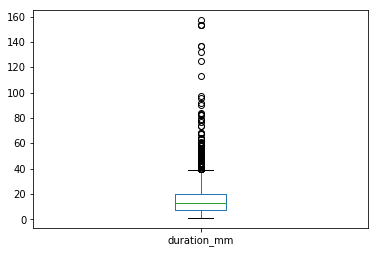

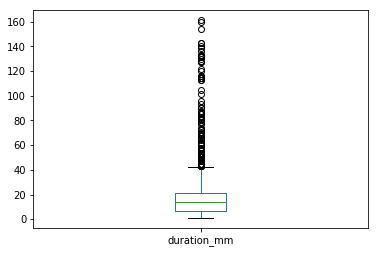

In [78]:
# Box plots - putting 2 into one cell
sdfCleanIn.duration_mm.plot(kind='box')
plt.show()
sdfCleanOut.duration_mm.plot(kind='box')
plt.show()

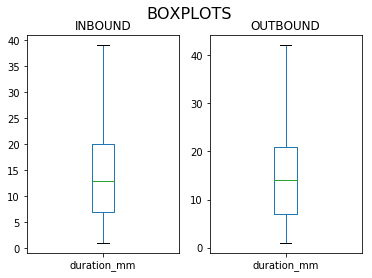

In [96]:
#The subplots gives the graphs side by side.  Note they do not have the same sccale on the y axis!

fig, axs = plt.subplots(1,2)
fig.suptitle("BOXPLOTS", fontsize=16)                                     # adding a title to the cell
ax1 = sdfCleanIn.duration_mm.plot(kind='box',showfliers=False,ax=axs[0])  # showfliers False removes the outliers from display
ax2 = sdfCleanOut.duration_mm.plot(kind='box',showfliers=False,ax=axs[1])
ax1.title.set_text('INBOUND')                                          # Adding sub-titles for each plot
ax2.title.set_text('OUTBOUND')


In [75]:
# Interpreting the whiskers on the boxplots. I will calculate the upper whisker for the Inbounds.
# Range for whiskers is [(Q1-1.5 IQR), (Q3+1.5 IQR)] 
iqr = np.subtract(*np.percentile(sdfCleanIn.duration_mm, [75, 25]))                        #IQR is interquartile range
print("INBOUND:")
print("Upper Whisker of Boxplot: ",1.5*iqr+ (np.percentile(sdfCleanIn.duration_mm, 75)))

# Calculating the proportion of trips longer than the uppper whisker
pct_above_upper_whisker = sdfCleanIn.query('duration_mm>= 39.5').rental_id.count()/sdfCleanIn.rental_id.count()*100
print("Percent above Upper Whisker:",pct_above_upper_whisker.round(1),"%")

INBOUND:
Upper Whisker of Boxplot:  39.5
Percent above Upper Whisker: 2.6 %


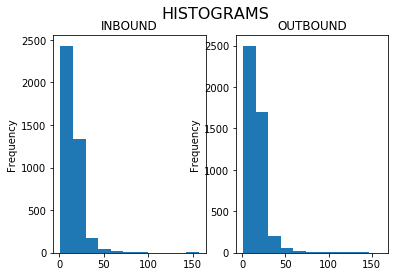

In [98]:
#The subplots gives the graphs side by side.  Note they do not necessarily have the same sccale on the y axis!

fig, axs = plt.subplots(1,2)
fig.suptitle("HISTOGRAMS", fontsize=16)
ax1 = sdfCleanIn.duration_mm.plot(kind='hist',bins=11, ax=axs[0])
ax2 = sdfCleanOut.duration_mm.plot(kind='hist', bins = 11, ax=axs[1])
#11 bins gives slots of approx 15 mins each, which is interesting for my analysis

ax1.title.set_text('INBOUND')                                          # Adding sub-titles for each plot
ax2.title.set_text('OUTBOUND')


In [49]:
print("BINS AND COUNTS FOR INBOUND")
print("01-15 min: ",sdfCleanIn[sdfCleanIn['duration_mm'].between(1, 15, inclusive=True)].rental_id.count())
print("16-29 min: ",sdfCleanIn[sdfCleanIn['duration_mm'].between(16, 29, inclusive=True)].rental_id.count())
print("30-44 min: ",sdfCleanIn[sdfCleanIn['duration_mm'].between(30, 44, inclusive=True)].rental_id.count())
print("45-49 min: ",sdfCleanIn[sdfCleanIn['duration_mm'].between(45, 49, inclusive=True)].rental_id.count())
print("50-64 min: ",sdfCleanIn[sdfCleanIn['duration_mm'].between(50, 64, inclusive=True)].rental_id.count())

print("\nBINS AND COUNTS FOR OUTBOUND")
print("01-15 min: ",sdfCleanOut[sdfCleanOut['duration_mm'].between(1, 15, inclusive=True)].rental_id.count())
print("16-29 min: ",sdfCleanOut[sdfCleanOut['duration_mm'].between(16, 29, inclusive=True)].rental_id.count())
print("30-44 min: ",sdfCleanOut[sdfCleanOut['duration_mm'].between(30, 44, inclusive=True)].rental_id.count())
print("45-49 min: ",sdfCleanOut[sdfCleanOut['duration_mm'].between(45, 49, inclusive=True)].rental_id.count())
print("50-64 min: ",sdfCleanOut[sdfCleanOut['duration_mm'].between(50, 64, inclusive=True)].rental_id.count())



BINS AND COUNTS FOR INBOUND
01-15 min:  2432
16-29 min:  1332
30-44 min:  178
45-49 min:  14
50-64 min:  35

BINS AND COUNTS FOR OUTBOUND
01-15 min:  2498
16-29 min:  1655
30-44 min:  244
45-49 min:  22
50-64 min:  40


## Conclusions from the Analysis
Once I was able to eliminate a small number of outliers, I was better able to create sensible visualisations of the datasets.
It was no surprise that the vast majority of trips come under 30 minutes, due to the pricing structure.
My initial hunch was that the 16-29 minute duration range would be the most common.  However, I discovered that there's actually a far stronger tendency to use the bikes for very short trips, up to 15 minutes.  This is supported by the analysis I did of the common connecting stations, which from my local knowledge I know are very close by.
There are no substantial differences in the patterns between the inbound and outbound rentals - perhaps just a bit more skewed towards the very short (under 15 mins) for the inbounds.
It's clear from the box plots that the data is centered around 13 minutes, with the top whisker showing 40 minutes (aka 1.5 times the interquartile range above the 75th percentile) - a mere 2.6% of the cleaned inbound dataset falls above this level.
The conclusion is that bike rentals to and from Salmon Lane docking station are used for many (very) short trips, and infrequently for long trips. 